In [37]:
from pydantic import BaseModel, Field
from typing import List
import numpy as np
import pandas as pd
from collections import defaultdict
import os

In [38]:
# parse tsplib file and generate a list of coordinates
def parse_tsplib_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if line.startswith('NODE_COORD_SECTION'):
                break
        coords = []
        for line in lines[i+1:]:
            if line.startswith('EOF'):
                break
            parts = line.split()
            coords.append((float(parts[1]), float(parts[2])))
        return coords

data = parse_tsplib_file('./tsplib/berlin52.tsp')

In [39]:
# override data with simple example 5x5 grid from -2 to 2
data = [(x, y) for x in np.linspace(-2, 2, 5) for y in np.linspace(-2, 2, 5)]

In [40]:
data

[(-2.0, -2.0),
 (-2.0, -1.0),
 (-2.0, 0.0),
 (-2.0, 1.0),
 (-2.0, 2.0),
 (-1.0, -2.0),
 (-1.0, -1.0),
 (-1.0, 0.0),
 (-1.0, 1.0),
 (-1.0, 2.0),
 (0.0, -2.0),
 (0.0, -1.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 2.0),
 (1.0, -2.0),
 (1.0, -1.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 2.0),
 (2.0, -2.0),
 (2.0, -1.0),
 (2.0, 0.0),
 (2.0, 1.0),
 (2.0, 2.0)]

In [41]:
import math


def calculate_distance(point1, point2):
    distance = math.sqrt((point1[0] - point2[0]) **
                         2 + (point1[1] - point2[1])**2)
    return distance

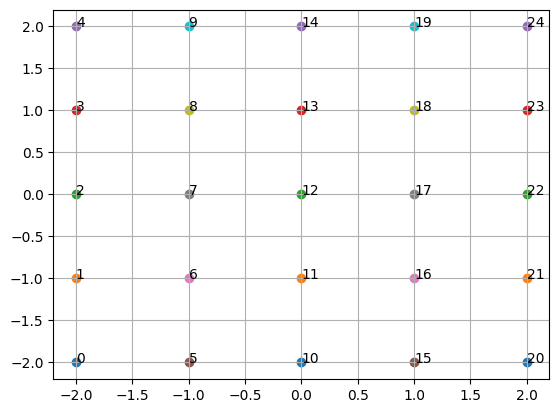

In [42]:
# show the data
import matplotlib.pyplot as plt

# label each point by its index
for i, point in enumerate(data):
    plt.scatter(point[0], point[1])
    plt.text(point[0], point[1], str(i))

plt.grid()
plt.show()

In [43]:
def calculate_distance_matrix(nodes: List[tuple]):
    """
    Calculates the Euclidean distance matrix between a set of nodes.

    Args:
                    nodes: A list of Node objects.

    Returns:
                    A NumPy array representing the distance matrix.
    """

    num_nodes = len(nodes)
    distance_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            distance_matrix[i][j] = np.sqrt(
                (nodes[i][0] - nodes[j][0])**2 + (nodes[i][1] - nodes[j][1])**2)

    return distance_matrix

In [44]:
def allocate_nodes_nearest_neighbor(nodes: List[tuple], hub_indices: List[int], distance_matrix: np.ndarray) -> dict:
    """
    Assigns non-hub nodes to their nearest hub using a nearest neighbor approach (hubs represented by indices).

    Args:
                    nodes: A list of all Node objects.
                    hub_indices:  A list of indices corresponding to hub nodes.
                    distance_matrix: A NumPy array representing distances between each pair of nodes.

    Returns:
                    A dictionary of assignments: {hub_index: [list of assigned non-hub nodes]}
    """
    assignments = defaultdict(list)
    for node_index, node in enumerate(nodes):
        if node_index in hub_indices:
            continue  # Skip if the node itself is a hub

        distances_to_hubs = [distance_matrix[node_index]
                             [hub_index] for hub_index in hub_indices]
        nearest_hub_index = hub_indices[np.argmin(distances_to_hubs)]
        assignments[nearest_hub_index].append(node_index)

    return assignments

In [45]:
def solve_ring_tsp_nearest_neighbor(distance_matrix: np.ndarray, hub_indices: List[int]) -> List[int]:
    """
    Solves the TSP to form an approximate ring connecting the selected hubs using the nearest neighbor algorithm.

    Args:
        distance_matrix: A NumPy array representing distances between each pair of nodes.
        hub_indices: A list of indices corresponding to the selected hub nodes.

    Returns:
        A list of hub indices (in the original node list) in the order they should be visited to form the approximate ring.
    """

    # Start with the first hub
    current_hub = hub_indices[0]

    # Initialize the list of hubs in the order they will be visited
    ordered_hubs = [current_hub]
    remaining_hubs = hub_indices[1:]

    while remaining_hubs:
        next_hub = remaining_hubs[np.argmin(
            distance_matrix[current_hub, remaining_hubs])]
        ordered_hubs.append(next_hub)
        remaining_hubs.remove(next_hub)
        current_hub = next_hub

    return ordered_hubs

In [46]:
# define the cost of edges between hubs and non-hubs

NON_HUB_EDGE_COST = 100000
HUB_EDGE_COST = 0.001

In [47]:
# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(data)

In [48]:
# define cost function
def cost_func(data: List[tuple], mask: List[int], distance_matrix: np.ndarray) -> float:
    """
    Calculates the fitness of a given mask, which represents a potential solution to the problem.

    Args:
                    mask: A list of integers representing the order in which the nodes will be visited.

    Returns:
                    The fitness of the mask.
    """
    # Create a list of hub indices and non-hub indices based on the mask
    hub_indices = [i for i, x in enumerate(mask) if x == 1]
    # non_hub_indices = [i for i, x in enumerate(mask) if x == 0]

    # All9ocate non-hub nodes to the nearest hub
    assignments = allocate_nodes_nearest_neighbor(
        data, hub_indices, distance_matrix)

    # print("Assignments: ", assignments)

    # Solve the TSP to form an approximate ring connecting the selected hubs
    ordered_hubs = solve_ring_tsp_nearest_neighbor(
        distance_matrix, hub_indices)

    # print("Ordered Hubs: ", ordered_hubs)

    # Calculate the total cost of the solution
    total_cost: float = 0

    # Add the cost of the edges between hubs
    for i in range(len(ordered_hubs)):
        total_cost += distance_matrix[ordered_hubs[i]
                                     ][ordered_hubs[(i+1) % len(ordered_hubs)]] * HUB_EDGE_COST
        
    # Add the cost of the edges between non-hub nodes and their assigned hubs
    for hub_index, assigned_nodes in assignments.items():
        for node_index in assigned_nodes:
            total_cost += distance_matrix[hub_index][node_index] * NON_HUB_EDGE_COST

    return total_cost

In [49]:
# define a pygad fitness function
def fitness_func(ga_instance, solution, solution_idx):
    cost = cost_func(data, solution, distance_matrix)

    # Since the problem is a minimization problem, we need to return the cost as a negative value
    return -cost

In [50]:
import pygad

num_generations = 100
sol_per_pop = 20

# starting mask, randomly generated
initial_mask = [[]]
for j in range(20):
    initial_mask.append([])
    for i in range(len(data)):
        initial_mask[j].append(np.random.randint(0, 2))

# Initialize a PyGAD instance
ga_instance = pygad.GA(gene_space=[0, 1],
                       num_generations=num_generations,
                       fitness_func=fitness_func,
                       num_parents_mating=20,
                       num_genes=len(data),
                       sol_per_pop=sol_per_pop,
                       crossover_type="single_point",
                       mutation_type="random"
                       )

In [51]:
ga_instance.run()

In [52]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(
    solution_fitness=solution_fitness))

Parameters of the best solution : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1.]
Fitness value of the best solution = -200000.02765685425


In [53]:
# a function to take a mask and print matplotlib plot
def ansViz(data, mask):
    # label each point by its index

    for i, point in enumerate(data):
        if mask[i] == 1:
            plt.scatter(point[0], point[1], color='red')
        else:
            plt.scatter(point[0], point[1], color='blue')
        plt.text(point[0], point[1], str(i))

    tmp1 = solve_ring_tsp_nearest_neighbor(distance_matrix, [i for i, x in enumerate(mask) if x == 1])

    # draw the ring
    for i in range(len(tmp1)):
        plt.plot([data[tmp1[i]][0], data[tmp1[(i+1) % len(tmp1)]][0]], [data[tmp1[i]][1], data[tmp1[(i+1) % len(tmp1)]][1]], color='green')

    tmp2 = allocate_nodes_nearest_neighbor(data, [i for i, x in enumerate(mask) if x == 1], distance_matrix)

    for hub_index, assigned_nodes in tmp2.items():
        for node_index in assigned_nodes:
            plt.plot([data[hub_index][0], data[node_index][0]], [data[hub_index][1], data[node_index][1]], color='black')

    plt.grid()
    plt.show()

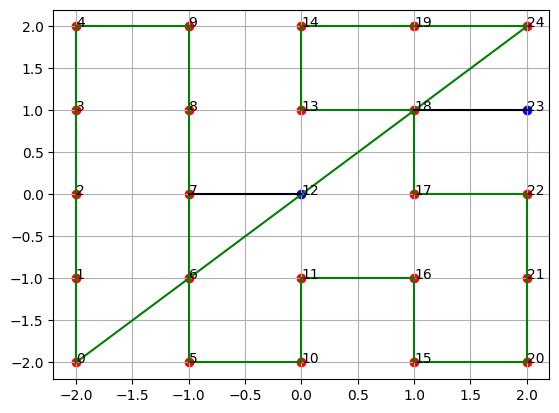

In [54]:
ansViz(data, solution)